In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_v2'
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_v2',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slic

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-3
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config

{'aug_type': 'soft', 'original_height': 128, 'original_width': 128, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 6, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 6,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [14]:
dataloaders_conf

{'train': {'batch_size': 32, 'num_workers': 8, 'shuffle': True},
 'val': {'batch_size': 32, 'num_workers': 8, 'shuffle': False},
 'test': {'batch_size': 32, 'num_workers': 8, 'shuffle': True}}

## Prepare train, validation and test data

In [15]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:00, 733.49it/s]
100%|██████████| 720/720 [00:07<00:00, 95.18it/s] 
8280it [00:00, 247587.40it/s]
7920it [00:00, 237911.63it/s]
700it [00:00, 885.43it/s]
100%|██████████| 700/700 [00:06<00:00, 102.82it/s]
8280it [00:00, 236967.94it/s]
7920it [00:00, 66898.17it/s]
710it [00:00, 868.47it/s]
100%|██████████| 710/710 [00:06<00:00, 104.29it/s]
7920it [00:00, 244621.66it/s]
7560it [00:00, 235229.51it/s]
720it [00:00, 857.64it/s]
100%|██████████| 720/720 [00:07<00:00, 96.52it/s] 
8280it [00:00, 241672.61it/s]
720it [00:03, 230.29it/s]
100%|██████████| 720/720 [00:07<00:00, 97.51it/s] 
25920it [00:00, 106738.08it/s]
700it [00:03, 227.98it/s]
100%|██████████| 700/700 [00:06<00:00, 103.08it/s]
25200it [00:00, 105160.56it/s]
509it [00:01, 390.21it/s]
100%|██████████| 509/509 [00:02<00:00, 198.73it/s]
8144it [00:00, 206309.22it/s]
700it [00:03, 228.69it/s]
100%|██████████| 700/700 [00:06<00:00, 103.29it/s]
25200it [00:00, 219343.69it/s]
700it [00:00, 730.42it/s]
100%|██████████| 700/700 [

In [16]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [17]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [18]:
device = 'cuda:1'
# device = 'cpu'

In [19]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.25304


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.089037
Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.063913


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.05467
Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.053716


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.053793
Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.050697


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.062499
EarlyStopping counter: 1 out of 15
Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.0472


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.047762
Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.045226


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.045277
Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.044242


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.045743
EarlyStopping counter: 1 out of 15
Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.043802


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.046416
EarlyStopping counter: 2 out of 15
Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.042947


100%|██████████| 732/732 [00:31<00:00, 23.46it/s]


Mean val loss: 0.044324


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.042834


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.048179
EarlyStopping counter: 1 out of 15
Epoch 10...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.042056


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.045943
EarlyStopping counter: 2 out of 15
Epoch 11...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.041659


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.045641
EarlyStopping counter: 3 out of 15
Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.04137


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.046041
EarlyStopping counter: 4 out of 15
Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.041184


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.044453
EarlyStopping counter: 5 out of 15
Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.040594


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.047098
EarlyStopping counter: 1 out of 15
Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.040343


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.050107
EarlyStopping counter: 2 out of 15
Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.040138


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.057516
EarlyStopping counter: 3 out of 15
Epoch 18...


 31%|███       | 237/765 [00:29<01:03,  8.25it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.038904


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.064333
EarlyStopping counter: 1 out of 15
Epoch 26...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.038993


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.047948
EarlyStopping counter: 2 out of 15
Epoch 27...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.038534


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.043082
EarlyStopping counter: 3 out of 15
Epoch 28...


 88%|████████▊ | 676/765 [01:23<00:11,  7.63it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.037617


100%|██████████| 732/732 [00:31<00:00, 23.49it/s]


Mean val loss: 0.039262


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.037547


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.040239
EarlyStopping counter: 1 out of 15
Epoch 37...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.037905


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.053757
EarlyStopping counter: 2 out of 15
Epoch 38...


 89%|████████▉ | 682/765 [01:23<00:10,  8.17it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.036894


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.039075
EarlyStopping counter: 3 out of 15
Epoch 47...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.036904


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.039058
EarlyStopping counter: 4 out of 15
Epoch 48...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.036728


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.04047
EarlyStopping counter: 5 out of 15
Epoch 49...


 21%|██        | 159/765 [00:20<01:12,  8.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.036372


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.03858
EarlyStopping counter: 3 out of 15
Epoch 57...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03632


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038817
EarlyStopping counter: 4 out of 15
Epoch 58...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.036271


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038911
EarlyStopping counter: 5 out of 15
Epoch 59...


 75%|███████▌  | 575/765 [01:11<00:22,  8.37it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 732/732 [00:31<00:00, 23.53it/s]


Mean val loss: 0.037879


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 67...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035939


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037934
EarlyStopping counter: 1 out of 15
Epoch 68...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03594


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038195
EarlyStopping counter: 2 out of 15
Epoch 69...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035883


 65%|██████▍   | 473/732 [00:20<00:10, 25.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037882
EarlyStopping counter: 1 out of 15
Epoch 77...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035569


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038169
EarlyStopping counter: 2 out of 15
Epoch 78...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035543


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037658
EarlyStopping counter: 3 out of 15
Epoch 79...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035541


 26%|██▌       | 192/732 [00:08<00:21, 25.22it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035341


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038105
EarlyStopping counter: 7 out of 15
Epoch 88...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035328


100%|██████████| 732/732 [00:30<00:00, 23.77it/s]


Mean val loss: 0.037159


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 89...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035244


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038401
EarlyStopping counter: 1 out of 15
Epoch 90...


  4%|▍         | 30/765 [00:04<01:31,  8.01it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035087


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037341
EarlyStopping counter: 9 out of 15
Epoch 98...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035073


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037872
EarlyStopping counter: 10 out of 15
Epoch 99...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.035011


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.039311
EarlyStopping counter: 11 out of 15
Epoch 100...


 47%|████▋     | 358/765 [00:44<00:49,  8.21it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034825


100%|██████████| 732/732 [00:31<00:00, 23.44it/s]


Mean val loss: 0.036797


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 108...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034829


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036922
EarlyStopping counter: 1 out of 15
Epoch 109...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034811


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036911
EarlyStopping counter: 2 out of 15
Epoch 110...


 86%|████████▋ | 660/765 [01:21<00:12,  8.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037269
EarlyStopping counter: 10 out of 15
Epoch 118...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034649


100%|██████████| 732/732 [00:30<00:00, 23.64it/s]


Mean val loss: 0.036759


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 119...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03465


100%|██████████| 732/732 [00:31<00:00, 23.53it/s]


Mean val loss: 0.036721


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 120...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034668


 29%|██▉       | 215/732 [00:09<00:20, 24.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034582


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036625
EarlyStopping counter: 2 out of 15
Epoch 125...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034532


100%|██████████| 732/732 [00:31<00:00, 23.58it/s]


Mean val loss: 0.036539


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 126...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034629


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.041751
EarlyStopping counter: 1 out of 15
Epoch 127...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034486


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036888
EarlyStopping counter: 2 out of 15
Epoch 128...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034434


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037011
EarlyStopping counter: 3 out of 15
Epoch 129...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034407


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036824
EarlyStopping counter: 4 out of 15
Epoch 130...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034423


100%|██████████| 732/732 [00:30<00:00, 23.64it/s]


Mean val loss: 0.036547


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 131...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034391


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037349
EarlyStopping counter: 1 out of 15
Epoch 132...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034336


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037897
EarlyStopping counter: 2 out of 15
Epoch 133...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034562


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037017
EarlyStopping counter: 3 out of 15
Epoch 134...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034423


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036755
EarlyStopping counter: 4 out of 15
Epoch 135...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034363


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036958
EarlyStopping counter: 5 out of 15
Epoch 136...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034348


100%|██████████| 732/732 [00:31<00:00, 23.56it/s]


Mean val loss: 0.03654


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 137...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034326


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.039996
EarlyStopping counter: 1 out of 15
Epoch 138...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034227


100%|██████████| 732/732 [00:31<00:00, 23.53it/s]


Mean val loss: 0.036292


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 139...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034276


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036566
EarlyStopping counter: 1 out of 15
Epoch 140...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034273


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.043201
EarlyStopping counter: 2 out of 15
Epoch 141...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034291


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036685
EarlyStopping counter: 3 out of 15
Epoch 142...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034157


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036617
EarlyStopping counter: 4 out of 15
Epoch 143...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034205


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036803
EarlyStopping counter: 5 out of 15
Epoch 144...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03416


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036995
EarlyStopping counter: 6 out of 15
Epoch 145...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034146


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037507
EarlyStopping counter: 7 out of 15
Epoch 146...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034157


100%|██████████| 732/732 [00:31<00:00, 23.56it/s]


Mean val loss: 0.036275


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 147...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034085


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.039014
EarlyStopping counter: 1 out of 15
Epoch 148...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03401


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.039158
EarlyStopping counter: 2 out of 15
Epoch 149...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034063


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036991
EarlyStopping counter: 3 out of 15
Epoch 150...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034026


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037929
EarlyStopping counter: 4 out of 15
Epoch 151...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034016


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037019
EarlyStopping counter: 5 out of 15
Epoch 152...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033995


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036971
EarlyStopping counter: 6 out of 15
Epoch 153...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034001


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037686
EarlyStopping counter: 7 out of 15
Epoch 154...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033975


100%|██████████| 732/732 [00:31<00:00, 23.50it/s]


Mean val loss: 0.036085


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 155...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033935


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.03802
EarlyStopping counter: 1 out of 15
Epoch 156...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.034004


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036505
EarlyStopping counter: 2 out of 15
Epoch 157...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033878


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036978
EarlyStopping counter: 3 out of 15
Epoch 158...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033862


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036221
EarlyStopping counter: 4 out of 15
Epoch 159...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033853


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036562
EarlyStopping counter: 5 out of 15
Epoch 160...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033906


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036925
EarlyStopping counter: 6 out of 15
Epoch 161...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033799


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.036934
EarlyStopping counter: 7 out of 15
Epoch 162...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033814


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.0371
EarlyStopping counter: 8 out of 15
Epoch 163...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033773


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037474
EarlyStopping counter: 9 out of 15
Epoch 164...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033725


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037453
EarlyStopping counter: 10 out of 15
Epoch 165...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033685


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.037687
EarlyStopping counter: 11 out of 15
Epoch 166...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033729


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038523
EarlyStopping counter: 12 out of 15
Epoch 167...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033671


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.039588
EarlyStopping counter: 13 out of 15
Epoch 168...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.03362


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.038189
EarlyStopping counter: 14 out of 15
Epoch 169...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.033588


100%|██████████| 732/732 [00:31<00:00, 23.49it/s]


Mean val loss: 0.037869
EarlyStopping counter: 15 out of 15


 38%|███▊      | 302/799 [03:17<05:21,  1.55it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

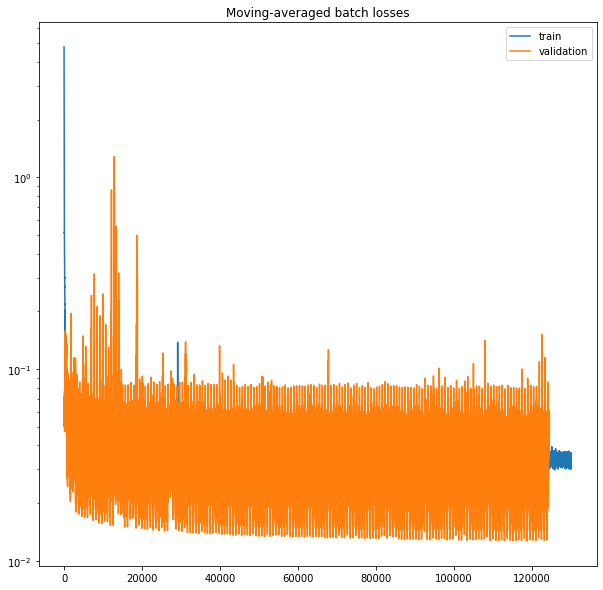

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

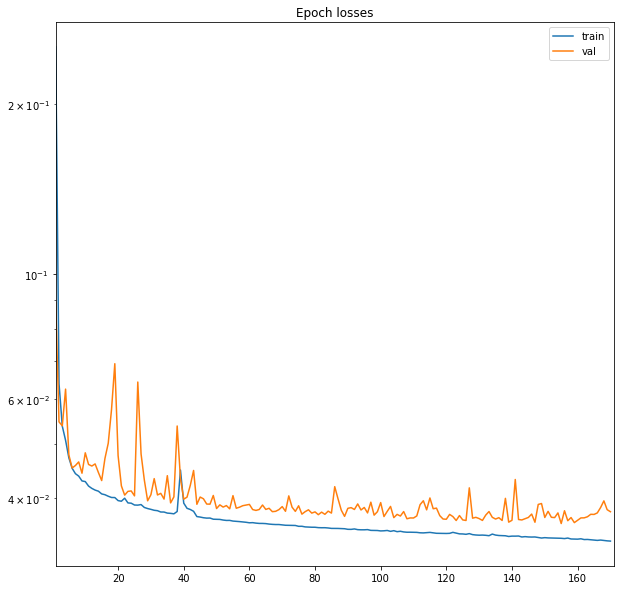

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996201,0.964140,0.996259,0.979937,0.999102,0.960662,carb96558,basic
1,0.985941,0.885012,0.996278,0.937355,0.974190,0.882096,carb71,basic
2,0.984032,0.940322,0.911205,0.925535,0.963134,0.861391,carbRNF,basic
3,0.994198,0.992646,0.937872,0.964482,0.996507,0.931400,SPE_carb10_58_box3,basic
4,0.991108,0.967938,0.932526,0.949902,0.992718,0.904585,SoilAh-1,basic
5,0.995304,0.947635,0.986250,0.966557,0.997122,0.935279,SoilB-2,basic
6,0.991445,0.995556,0.937168,0.965480,0.980987,0.933263,TeTree_subset1,basic
7,0.993629,0.994350,0.948426,0.970845,0.985368,0.943342,TiTree_subset2,basic
8,0.992668,0.951496,0.993940,0.972255,0.998173,0.946007,Urna_22,basic
9,0.990481,0.959565,0.984809,0.972023,0.997878,0.945569,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.9229
Std    IOU: 0.030369
Min    IOU: 0.86139
Median IOU: 0.93326


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [20]:
from stack_segmentation.training import make_joint_loss

In [21]:
import torch

In [22]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [23]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [40]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0055
MEan 1 loss: 0.0009
Mean of ratios: 6.3925
Ratio of means: 5.9887
